In [1]:
import warnings

# The workhorses
import pandas as pd
import numpy as np

# Plotting modules
import matplotlib.pyplot as plt
import matplotlib.patches

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Seaborn makes plots look nice
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
sns.set_style('darkgrid', {'axes.facecolor': '(0.875, 0.875, 0.9)'})

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Load data
df = pd.read_csv('data/mean_rest_bouts.csv', comment='#')

# Pull out wild type and mutant and take NaNs to be zero
df = df[df['genotype'].isin(['wt', 'mut'])].fillna(0)

In [22]:
wt = df[df['genotype']=='wt']['mean_rest_bout_length']
mut = df[df['genotype']=='mut']['mean_rest_bout_length']

## Problem 5.1a Frequentist parameter estimation

We are assuming that both the wild-type and mutant bout-lengths have Gaussian distributions and want unbiased estimators for $\mu_i$ and $\sigma_i^2$, where $i \in \{w,m\}$. These are, respectively, the sample mean:
$$\bar{x_i} = \frac{1}{n_i}\sum_{x_j \in i} x_j$$
and the sample variance:
$$s_i^ 2 = \frac{1}{n_i-1}\sum_{x_j \in i} (x_j - \bar{x_i})^ 2$$

We will use the built-in functions in Pandas to calculate these. 

In [24]:
x_bar_w = wt.mean()
x_bar_m = mut.mean()
var_w = wt.var(ddof=1)
var_m = mut.var(ddof=1)
print ('            mean (min)   variance (min²)')
print ('wild-type:  %.3f        %.3f' %(x_bar_w, var_w))
print ('mutant:     %.3f        %.3f' %(x_bar_m, var_m))

            mean (min)   variance (min²)
wild-type:  2.209        0.273
mutant:     1.727        0.648


We also want to calculate Cohen's d as an estimate of the effect size. 

In [25]:
def cohen_d(x, y, return_abs=False):
    """
    Cohen's d
    """
    diff = y.mean() - x.mean()
    pooled_variance = (len(x) * x.var() + len(y) * y.var()) / (len(x) + len(y))

    if return_abs:
        return np.abs(diff) / np.sqrt(pooled_variance)
    return diff / np.sqrt(pooled_variance)

actual_d = cohen_d (wt,mut)

print ("Cohen's d = %.4f" %actual_d)

Cohen's d = -0.6927


## Problem 5.1b Frequentist estimation of the difference

Let's do this by bootstrapping. First, let's make a function that draws bootstrap samples and uses them to estimate some parameter. 

In [28]:
def bootstrap_estimate (x, param_fun, args=(), replicates=1000):
    """Estimates a parameter by drawing bootstrap samples of x. """
    n = len(x)
    return np.array([param_fun(np.random.choice(x, n, replace=True)) \
            for r in range(replicates)])

Now, let's use this function to calculate $\delta = \bar{x_w} - \bar{x_m}$ for 1000 bootstrap samples. 

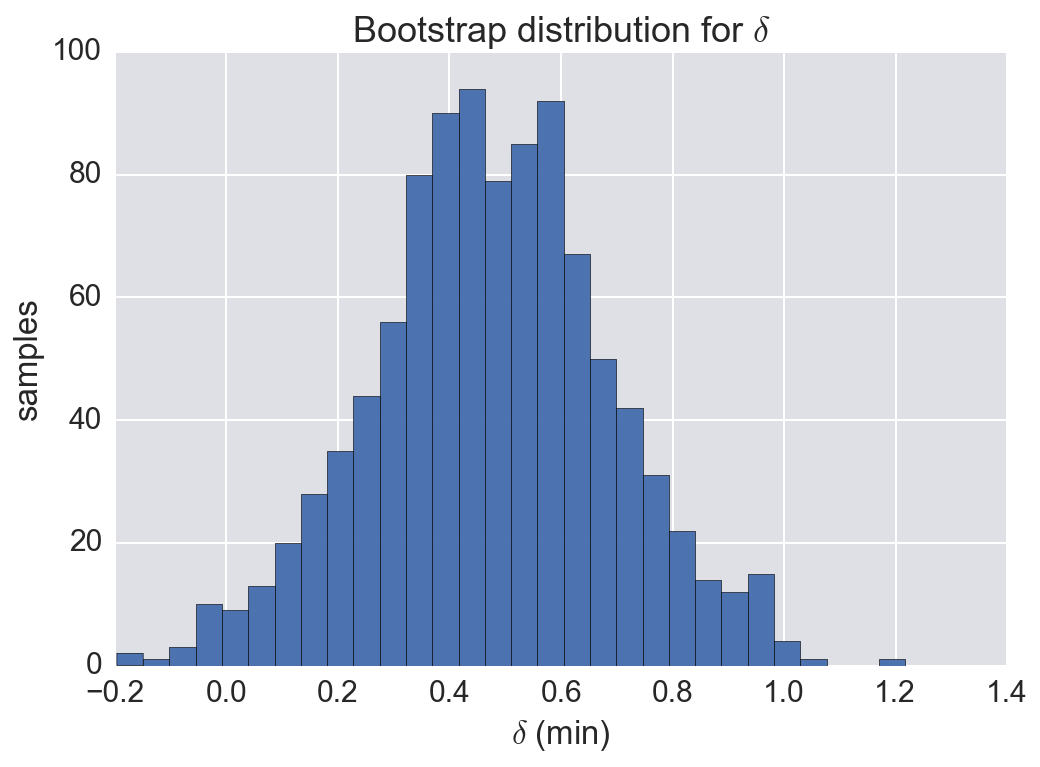

In [56]:
deltas = bootstrap_estimate (wt, np.mean) - bootstrap_estimate(mut, np.mean)
_ = plt.hist(deltas, bins=30)
plt.xlabel ('$\delta$ (min)')
plt.ylabel ('samples')
plt.title ('Bootstrap distribution for $\delta$')

That looks Gaussian enough that we can use the mean as the best estimate. We'll use the 2.5th and 97.5th percentiles to get a 95% confidence interval. 

In [55]:
delta_bar = np.mean(deltas)
CI = tuple(np.percentile (deltas, (2.5, 97.5)))
print ('The mean bootstrap value for delta is %.4f minutes.' % delta_bar)
print ('The 95%% confidence interval for delta is (%.4f,%.4f) minutes.' %CI)

The mean bootstrap value for delta is 0.4864 minutes.
The 95% confidence interval for delta is (0.0881,0.9088) minutes.
